In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__  




'2.1.0'

In [105]:
from tensorflow.keras.layers import Input,Dense,LeakyReLU,Flatten,Dropout,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD,Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys,os

In [106]:
def reset_weights(model):
  for layer in model.layers: 
    if isinstance(layer, tf.keras.Model):
      reset_weights(layer)
      continue
    for k, initializer in layer.__dict__.items():
      if "initializer" not in k:
        continue
      # find the corresponding variable
      var = getattr(layer, k.replace("_initializer", ""))
      var.assign(initializer(var.shape, var.dtype))

In [107]:
DIR='AI\\data\\'

In [108]:
def plot_confusion_matrix(cm,classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
  if normalize:
    cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    print("Noramlized confusion matrix")
  else:
    print("Confusion matrix without normalisation")
  print(cm)
  plt.imshow(cm,interpolation='nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  ticks_marks=np.arange(len(classes))
  plt.xticks(ticks_marks,classes,rotation=45)
  plt.yticks(ticks_marks,classes)

  fmt='.2f' if normalize else 'd'
  thresh = cm.max()/2
  for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i, format(cm[i,j],fmt),
            horizontalalignment="center",
            color="white" if cm[i,j] >thresh else "black")
  plt.tight_layout()
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.show()

In [109]:
df = pd.read_csv(DIR+"conected_v6.csv",index_col=0) 

In [110]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,Y_1_1.0,Y_2_1.0,Y_3_1.0,Y_4_1.0,Y_5_1.0,Y_1_1.5,Y_2_1.5,Y_3_1.5,Y_4_1.5,Y_5_1.5
count,3.562000e+03,3.562000e+03,3.562000e+03,3.562000e+03,3.562000e+03,3.562000e+03,3.562000e+03,3.562000e+03,3.562000e+03,3.562000e+03,...,3562.000000,3562.000000,3562.000000,3562.000000,3562.000000,3562.000000,3562.000000,3562.000000,3562.000000,3562.000000
mean,1.018588e-16,-4.070610e-17,5.261248e-17,-4.594241e-17,-2.231667e-17,8.876797e-17,8.085117e-17,2.906465e-17,4.993978e-17,1.994786e-18,...,1.008703,1.011510,1.010107,1.017687,1.017125,1.001123,1.005615,1.003650,1.005896,1.000561
std,1.000140e+00,1.000140e+00,1.000140e+00,1.000140e+00,1.000140e+00,1.000140e+00,1.000140e+00,1.000140e+00,1.000140e+00,1.000140e+00,...,0.351804,0.409974,0.431697,0.446486,0.452754,0.270207,0.310758,0.326217,0.331309,0.338488
min,-1.737056e+00,-1.720600e+00,-1.955018e+00,-2.196802e+00,-1.738458e+00,-1.740432e+00,-1.742732e+00,-1.742516e+00,-1.741841e+00,-1.740747e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-5.709234e-01,-6.532999e-01,-7.172368e-01,-7.405472e-01,-5.716074e-01,-5.719506e-01,-5.725321e-01,-5.725910e-01,-5.722679e-01,-5.714259e-01,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,-2.964976e-01,-1.686186e-01,-2.475078e-01,-8.964455e-02,-2.970115e-01,-2.968993e-01,-2.973176e-01,-2.973786e-01,-2.970482e-01,-2.962483e-01,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,3.896311e-01,4.028162e-01,4.709480e-01,6.166091e-01,3.934660e-01,3.954619e-01,3.954785e-01,3.966683e-01,3.969600e-01,3.972705e-01,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,9.415348e+00,1.012345e+01,4.935591e+00,8.001005e+00,9.411912e+00,9.410736e+00,9.409551e+00,9.409414e+00,9.410004e+00,9.409490e+00,...,2.000000,3.000000,3.000000,3.000000,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000


In [111]:
Y=df.iloc[:,204]
X=df.iloc[:,:204]
X,Y

(            0         1         2         3         4         5         6  \
 0   -0.049035 -0.565848  0.736594 -1.071490  0.038483 -0.177512  0.094612   
 1    0.039335 -0.580337  0.725564 -1.054353 -0.177136  0.095233  0.230416   
 2   -0.176343 -0.245664  0.112186 -0.392810  0.095632  0.231046  0.164146   
 3    0.096500 -0.232964  0.484342 -0.378075  0.231456  0.164772  0.164752   
 4    0.232361 -0.272170  0.828325 -0.454012  0.165177  0.165378  0.106081   
 ..        ...       ...       ...       ...       ...       ...       ...   
 887  0.184166  1.962744 -0.021661  0.587204  0.731257  0.964081  1.041825   
 888  0.735659  0.545087  0.702022 -0.384440  0.970953  1.044492  3.235707   
 889  0.975711 -0.468227  0.813919 -1.084755  1.051636  3.239496  1.909412   
 890  1.056514 -0.999973  0.973794 -1.424199  3.254083  1.912523  2.535719   
 891  3.262236 -0.875181  2.459207 -1.464391  1.922611  2.539150  1.189975   
 
             7         8         9  ...       194       195   

In [112]:
N,D=X.shape
N,D
X=np.asarray(X)
Y=np.asarray(Y)
Y = Y.astype(np.float)

X=df.iloc[:,:204]
Y.shape[0]
X_rand=np.random.randn(X.shape[0],X.shape[1])
Y_rand=np.random.randint(2,size=Y.shape[0]).astype(np.float)

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.33)

In [113]:
i=Input(shape=(D,))
x=Dense(256,activation='relu')(i)
#x=Dropout(0.3)(x)
#x=BatchNormalization(momentum=0.8)(x)
#x=Dense(256,activation='relu')(x)
#x=Dense(256,activation='relu')(x)
x=Dense(4,activation='softmax')(x)

model=Model(i,x)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#weights = model.get_weights()
#reset_model = lambda model: model.set_weights(weights)


In [114]:
r_rand=model.fit(X_rand,Y_rand,validation_split=0.3,epochs=10)
reset_weights(model)
r=model.fit(X_train,Y_train,validation_data=[X_test,Y_test],epochs=10)


Train on 2493 samples, validate on 1069 samples
Epoch 1/10
2493/2493 [==============================] - 1s 505us/sample - loss: 1.0393 - accuracy: 0.4473 - val_loss: 0.8017 - val_accuracy: 0.4855
Epoch 2/10
2493/2493 [==============================] - 0s 117us/sample - loss: 0.6229 - accuracy: 0.6663 - val_loss: 0.7946 - val_accuracy: 0.5070
Epoch 3/10
2493/2493 [==============================] - 0s 124us/sample - loss: 0.5155 - accuracy: 0.7633 - val_loss: 0.8013 - val_accuracy: 0.5089
Epoch 4/10
2493/2493 [==============================] - 0s 124us/sample - loss: 0.4152 - accuracy: 0.8777 - val_loss: 0.8184 - val_accuracy: 0.4986
Epoch 5/10
2493/2493 [==============================] - 0s 134us/sample - loss: 0.3229 - accuracy: 0.9410 - val_loss: 0.8567 - val_accuracy: 0.4949
Epoch 6/10
2493/2493 [==============================] - 0s 137us/sample - loss: 0.2365 - accuracy: 0.9751 - val_loss: 0.8808 - val_accuracy: 0.5042
Epoch 7/10
2493/2493 [==============================] - 0s 125us

Confusion matrix without normalisation
[[ 25 151  36]
 [ 58 562 109]
 [ 16 175  44]]


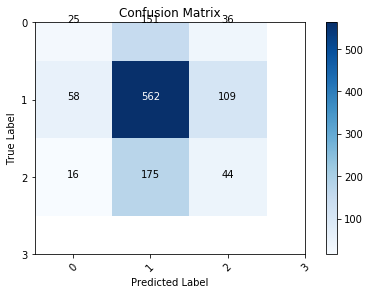

In [115]:
p_test=model.predict(X_test).argmax(axis=1)
cm=confusion_matrix(Y_test,p_test)
plot_confusion_matrix(cm,list(range(4)),normalize=False)

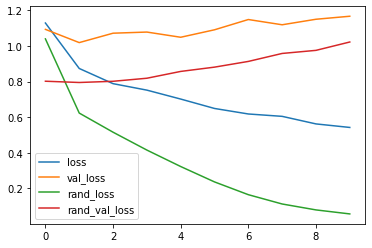

In [116]:
import matplotlib.pyplot as plt
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.plot(r_rand.history['loss'],label='rand_loss')
plt.plot(r_rand.history['val_loss'],label='rand_val_loss')
plt.legend()

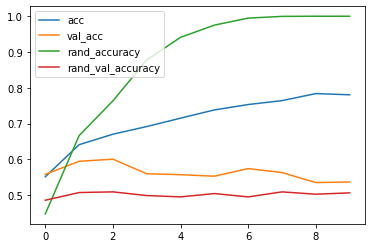

In [117]:
plt.plot(r.history['accuracy'],label='acc')
plt.plot(r.history['val_accuracy'],label='val_acc')
plt.plot(r_rand.history['accuracy'],label='rand_accuracy')
plt.plot(r_rand.history['val_accuracy'],label='rand_val_accuracy')
plt.legend()
reset_weights(model)

In [128]:
ran=5
matrix_p=np.zeros((4,10,ran))
matrix_p

array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
    

****Running: 0 ******
Prediction for Y_1_0.0
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 121us/sample - loss: 0.9266 - accuracy: 0.6287 - val_loss: 0.9016 - val_accuracy: 0.6531
Epoch 2/5
2386/2386 [==============================] - 0s 134us/sample - loss: 0.8348 - accuracy: 0.6526 - val_loss: 0.9483 - val_accuracy: 0.6224
Epoch 3/5
2386/2386 [==============================] - 0s 132us/sample - loss: 0.7696 - accuracy: 0.6777 - val_loss: 0.9498 - val_accuracy: 0.6071
Epoch 4/5
2386/2386 [==============================] - 0s 132us/sample - loss: 0.7307 - accuracy: 0.6894 - val_loss: 0.9356 - val_accuracy: 0.5986
Epoch 5/5
2386/2386 [==============================] - 0s 130us/sample - loss: 0.7006 - accuracy: 0.7150 - val_loss: 0.9535 - val_accuracy: 0.6216
Prediction for Y_1_0.0
Confusion matrix without normalisation
[[ 16 150  24]
 [ 26 678  56]
 [ 12 177  37]]


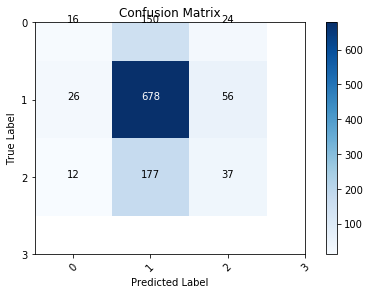

Plus 0.3162393162393162 Minus 0.2962962962962963
{'loss': 0.7005835453802463, 'val_loss': 0.9535037571070145, 'p_m': 0.08421052631578947, 'p_m_acc': 0.2962962962962963, 'p_p': 0.16371681415929204, 'p_p_acc': 0.3162393162393162, 'p_p_acc_2': 0.6065573770491803, 'p_m_acc_2': 0.5714285714285714}
Prediction for Y_2_0.0
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 145us/sample - loss: 1.2225 - accuracy: 0.4409 - val_loss: 1.0981 - val_accuracy: 0.5332
Epoch 2/5
2386/2386 [==============================] - 0s 131us/sample - loss: 0.9942 - accuracy: 0.5314 - val_loss: 1.0982 - val_accuracy: 0.5077
Epoch 3/5
2386/2386 [==============================] - 0s 122us/sample - loss: 0.8782 - accuracy: 0.6094 - val_loss: 1.1298 - val_accuracy: 0.4830
Epoch 4/5
2386/2386 [==============================] - 0s 119us/sample - loss: 0.8302 - accuracy: 0.6404 - val_loss: 1.1122 - val_accuracy: 0.5068
Epoch 5/5
2386/2386 [==========================

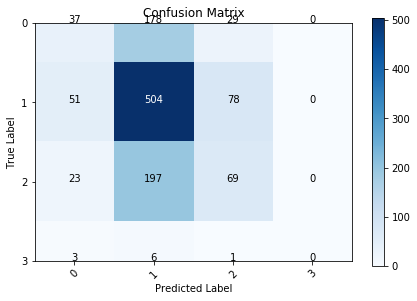

Plus 0.39204545454545453 Minus 0.3333333333333333
{'loss': 0.7639455078333641, 'val_loss': 1.1245655514756028, 'p_m': 0.15163934426229508, 'p_m_acc': 0.3333333333333333, 'p_p': 0.23875432525951557, 'p_p_acc': 0.39204545454545453, 'p_p_acc_2': 0.7040816326530612, 'p_m_acc_2': 0.6166666666666667}
Prediction for Y_3_0.0
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 132us/sample - loss: 1.2413 - accuracy: 0.4216 - val_loss: 1.1718 - val_accuracy: 0.4422
Epoch 2/5
2386/2386 [==============================] - 0s 118us/sample - loss: 0.9975 - accuracy: 0.5360 - val_loss: 1.1050 - val_accuracy: 0.4889
Epoch 3/5
2386/2386 [==============================] - 0s 122us/sample - loss: 0.9024 - accuracy: 0.5897 - val_loss: 1.1342 - val_accuracy: 0.4719
Epoch 4/5
2386/2386 [==============================] - 0s 122us/sample - loss: 0.8298 - accuracy: 0.6475 - val_loss: 1.0751 - val_accuracy: 0.5026
Epoch 5/5
2386/2386 [========================

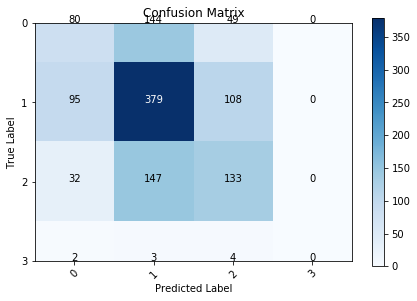

Plus 0.4586206896551724 Minus 0.3864734299516908
{'loss': 0.7831738220975865, 'val_loss': 1.0882358851075984, 'p_m': 0.29304029304029305, 'p_m_acc': 0.3864734299516908, 'p_p': 0.42628205128205127, 'p_p_acc': 0.4586206896551724, 'p_p_acc_2': 0.7307692307692307, 'p_m_acc_2': 0.7142857142857143}
Prediction for Y_4_0.0
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 178us/sample - loss: 1.2364 - accuracy: 0.4111 - val_loss: 1.1304 - val_accuracy: 0.4626
Epoch 2/5
2386/2386 [==============================] - 0s 131us/sample - loss: 0.9945 - accuracy: 0.5327 - val_loss: 1.1319 - val_accuracy: 0.4668
Epoch 3/5
2386/2386 [==============================] - 0s 117us/sample - loss: 0.8775 - accuracy: 0.6111 - val_loss: 1.1202 - val_accuracy: 0.4898
Epoch 4/5
2386/2386 [==============================] - 0s 170us/sample - loss: 0.8232 - accuracy: 0.6446 - val_loss: 1.1424 - val_accuracy: 0.4753
Epoch 5/5
2386/2386 [==========================

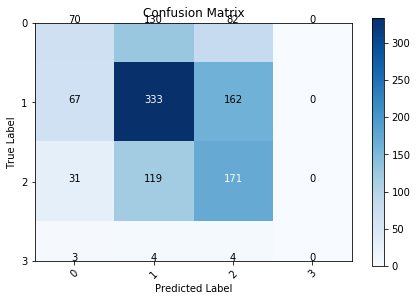

Plus 0.41204819277108434 Minus 0.4166666666666667
{'loss': 0.7625273256269904, 'val_loss': 1.127505553822939, 'p_m': 0.24822695035460993, 'p_m_acc': 0.4166666666666667, 'p_p': 0.5327102803738317, 'p_p_acc': 0.41204819277108434, 'p_p_acc_2': 0.6758893280632411, 'p_m_acc_2': 0.693069306930693}
Prediction for Y_5_0.0
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 130us/sample - loss: 1.2439 - accuracy: 0.4149 - val_loss: 1.0889 - val_accuracy: 0.4728
Epoch 2/5
2386/2386 [==============================] - 0s 126us/sample - loss: 0.9789 - accuracy: 0.5453 - val_loss: 1.1349 - val_accuracy: 0.4541
Epoch 3/5
2386/2386 [==============================] - 0s 119us/sample - loss: 0.8860 - accuracy: 0.6069 - val_loss: 1.0665 - val_accuracy: 0.5051
Epoch 4/5
2386/2386 [==============================] - 0s 148us/sample - loss: 0.8091 - accuracy: 0.6475 - val_loss: 1.0716 - val_accuracy: 0.5136
Epoch 5/5
2386/2386 [===========================

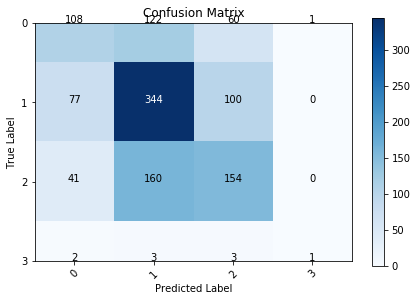

Plus 0.49044585987261147 Minus 0.4778761061946903
{'loss': 0.7515431774931601, 'val_loss': 1.0755234575595984, 'p_m': 0.3711340206185567, 'p_m_acc': 0.4778761061946903, 'p_p': 0.43380281690140843, 'p_p_acc': 0.49044585987261147, 'p_p_acc_2': 0.719626168224299, 'p_m_acc_2': 0.7248322147651006}
Prediction for Y_1_0.5
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 135us/sample - loss: 0.8224 - accuracy: 0.7464 - val_loss: 0.6751 - val_accuracy: 0.7993
Epoch 2/5
2386/2386 [==============================] - 0s 121us/sample - loss: 0.6633 - accuracy: 0.7712 - val_loss: 0.6952 - val_accuracy: 0.7951
Epoch 3/5
2386/2386 [==============================] - 0s 135us/sample - loss: 0.6080 - accuracy: 0.7842 - val_loss: 0.6743 - val_accuracy: 0.7934
Epoch 4/5
2386/2386 [==============================] - 0s 121us/sample - loss: 0.5574 - accuracy: 0.7955 - val_loss: 0.7687 - val_accuracy: 0.7534
Epoch 5/5
2386/2386 [==========================

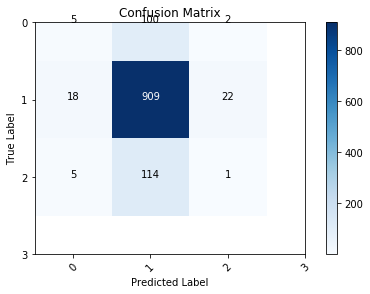

Plus 0.04 Minus 0.17857142857142858
{'loss': 0.5328103583196783, 'val_loss': 0.6916725242219004, 'p_m': 0.04672897196261682, 'p_m_acc': 0.17857142857142858, 'p_p': 0.008333333333333333, 'p_p_acc': 0.04, 'p_p_acc_2': 0.3333333333333333, 'p_m_acc_2': 0.5}
Prediction for Y_2_0.5
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 134us/sample - loss: 0.9685 - accuracy: 0.6454 - val_loss: 0.8506 - val_accuracy: 0.6896
Epoch 2/5
2386/2386 [==============================] - 0s 119us/sample - loss: 0.7675 - accuracy: 0.7033 - val_loss: 0.8172 - val_accuracy: 0.7151
Epoch 3/5
2386/2386 [==============================] - 0s 141us/sample - loss: 0.6883 - accuracy: 0.7364 - val_loss: 0.8306 - val_accuracy: 0.6998
Epoch 4/5
2386/2386 [==============================] - 0s 134us/sample - loss: 0.6486 - accuracy: 0.7502 - val_loss: 0.8448 - val_accuracy: 0.7075
Epoch 5/5
2386/2386 [==============================] - 0s 121us/sample - loss: 0.5936 -

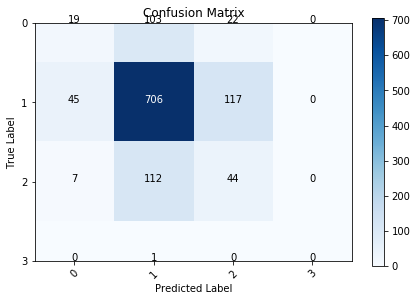

Plus 0.24043715846994534 Minus 0.2676056338028169
{'loss': 0.593649078994265, 'val_loss': 0.8743127535800544, 'p_m': 0.13194444444444445, 'p_m_acc': 0.2676056338028169, 'p_p': 0.26993865030674846, 'p_p_acc': 0.24043715846994534, 'p_p_acc_2': 0.6666666666666666, 'p_m_acc_2': 0.7307692307692307}
Prediction for Y_3_0.5
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 1s 210us/sample - loss: 0.9729 - accuracy: 0.6220 - val_loss: 0.9063 - val_accuracy: 0.6582
Epoch 2/5
2386/2386 [==============================] - 0s 147us/sample - loss: 0.7987 - accuracy: 0.6823 - val_loss: 0.8448 - val_accuracy: 0.6667
Epoch 3/5
2386/2386 [==============================] - 0s 120us/sample - loss: 0.6943 - accuracy: 0.7158 - val_loss: 0.8271 - val_accuracy: 0.6896
Epoch 4/5
2386/2386 [==============================] - 0s 119us/sample - loss: 0.6250 - accuracy: 0.7515 - val_loss: 0.8517 - val_accuracy: 0.6888
Epoch 5/5
2386/2386 [=========================

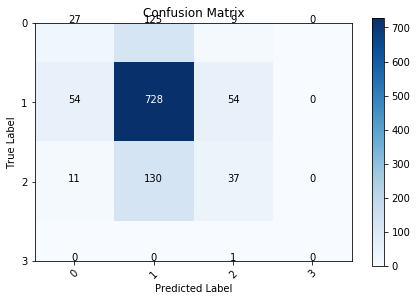

Plus 0.37 Minus 0.29347826086956524
{'loss': 0.593019195744098, 'val_loss': 0.8426448301393159, 'p_m': 0.16770186335403728, 'p_m_acc': 0.29347826086956524, 'p_p': 0.20786516853932585, 'p_p_acc': 0.37, 'p_p_acc_2': 0.8043478260869565, 'p_m_acc_2': 0.7105263157894737}
Prediction for Y_4_0.5
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 1s 210us/sample - loss: 1.0401 - accuracy: 0.5901 - val_loss: 0.8918 - val_accuracy: 0.6344
Epoch 2/5
2386/2386 [==============================] - 0s 156us/sample - loss: 0.8009 - accuracy: 0.6618 - val_loss: 0.8792 - val_accuracy: 0.6344
Epoch 3/5
2386/2386 [==============================] - 0s 119us/sample - loss: 0.7157 - accuracy: 0.7012 - val_loss: 0.8443 - val_accuracy: 0.6752
Epoch 4/5
2386/2386 [==============================] - 0s 124us/sample - loss: 0.6499 - accuracy: 0.7385 - val_loss: 0.8587 - val_accuracy: 0.6607
Epoch 5/5
2386/2386 [==============================] - 0s 144us/sample - l

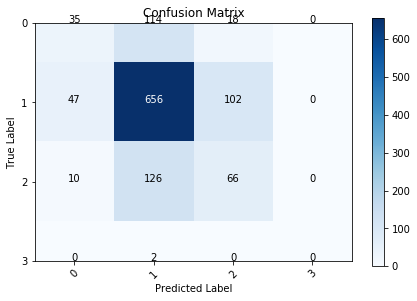

Plus 0.3548387096774194 Minus 0.3804347826086957
{'loss': 0.5910976421703137, 'val_loss': 0.8576610137005242, 'p_m': 0.20958083832335328, 'p_m_acc': 0.3804347826086957, 'p_p': 0.32673267326732675, 'p_p_acc': 0.3548387096774194, 'p_p_acc_2': 0.7857142857142857, 'p_m_acc_2': 0.7777777777777778}
Prediction for Y_5_0.5
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 186us/sample - loss: 1.0685 - accuracy: 0.5641 - val_loss: 0.8937 - val_accuracy: 0.6241
Epoch 2/5
2386/2386 [==============================] - 0s 120us/sample - loss: 0.7958 - accuracy: 0.6681 - val_loss: 0.8607 - val_accuracy: 0.6616
Epoch 3/5
2386/2386 [==============================] - 0s 131us/sample - loss: 0.7174 - accuracy: 0.7062 - val_loss: 0.8481 - val_accuracy: 0.6641
Epoch 4/5
2386/2386 [==============================] - 0s 121us/sample - loss: 0.6407 - accuracy: 0.7427 - val_loss: 0.8544 - val_accuracy: 0.6437
Epoch 5/5
2386/2386 [==========================

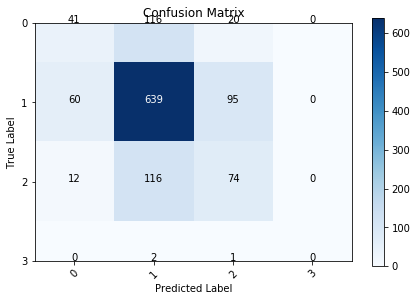

Plus 0.3915343915343915 Minus 0.36283185840707965
{'loss': 0.5967110609268802, 'val_loss': 0.867142974924879, 'p_m': 0.23163841807909605, 'p_m_acc': 0.36283185840707965, 'p_p': 0.36633663366336633, 'p_p_acc': 0.3915343915343915, 'p_p_acc_2': 0.7872340425531915, 'p_m_acc_2': 0.7735849056603774}
****Running: 1 ******
Prediction for Y_1_0.0
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 131us/sample - loss: 1.1577 - accuracy: 0.5348 - val_loss: 0.9994 - val_accuracy: 0.5672
Epoch 2/5
2386/2386 [==============================] - 0s 119us/sample - loss: 0.8794 - accuracy: 0.6282 - val_loss: 0.9874 - val_accuracy: 0.5893
Epoch 3/5
2386/2386 [==============================] - 0s 121us/sample - loss: 0.7987 - accuracy: 0.6676 - val_loss: 1.0171 - val_accuracy: 0.5672
Epoch 4/5
2386/2386 [==============================] - 0s 119us/sample - loss: 0.7539 - accuracy: 0.6899 - val_loss: 1.0110 - val_accuracy: 0.5893
Epoch 5/5
2386/2386 [===

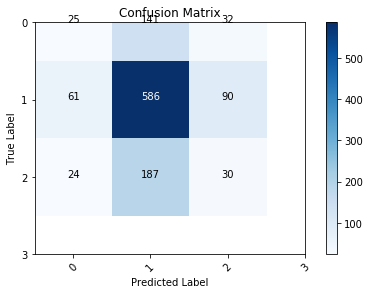

Plus 0.19736842105263158 Minus 0.22727272727272727
{'loss': 0.7108110858428808, 'val_loss': 1.058572834040843, 'p_m': 0.12626262626262627, 'p_m_acc': 0.22727272727272727, 'p_p': 0.12448132780082988, 'p_p_acc': 0.19736842105263158, 'p_p_acc_2': 0.4838709677419355, 'p_m_acc_2': 0.5102040816326531}
Prediction for Y_2_0.0
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 134us/sample - loss: 1.2214 - accuracy: 0.4526 - val_loss: 1.1590 - val_accuracy: 0.4660
Epoch 2/5
2386/2386 [==============================] - 0s 120us/sample - loss: 0.9800 - accuracy: 0.5469 - val_loss: 1.1437 - val_accuracy: 0.4711
Epoch 3/5
2386/2386 [==============================] - 0s 119us/sample - loss: 0.8952 - accuracy: 0.6065 - val_loss: 1.1380 - val_accuracy: 0.4694
Epoch 4/5
2386/2386 [==============================] - 0s 124us/sample - loss: 0.8313 - accuracy: 0.6400 - val_loss: 1.1317 - val_accuracy: 0.5009
Epoch 5/5
2386/2386 [=======================

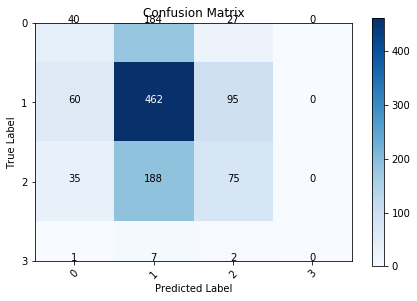

Plus 0.38071065989847713 Minus 0.2962962962962963
{'loss': 0.779339027374808, 'val_loss': 1.1368328057178834, 'p_m': 0.1593625498007968, 'p_m_acc': 0.2962962962962963, 'p_p': 0.2516778523489933, 'p_p_acc': 0.38071065989847713, 'p_p_acc_2': 0.7352941176470589, 'p_m_acc_2': 0.5333333333333333}
Prediction for Y_3_0.0
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 139us/sample - loss: 1.2208 - accuracy: 0.4258 - val_loss: 1.1949 - val_accuracy: 0.4439
Epoch 2/5
2386/2386 [==============================] - 0s 120us/sample - loss: 0.9982 - accuracy: 0.5352 - val_loss: 1.1192 - val_accuracy: 0.4762
Epoch 3/5
2386/2386 [==============================] - ETA: 0s - loss: 0.8803 - accuracy: 0.59 - 0s 122us/sample - loss: 0.8914 - accuracy: 0.5956 - val_loss: 1.1479 - val_accuracy: 0.4668
Epoch 4/5
2386/2386 [==============================] - 0s 124us/sample - loss: 0.8209 - accuracy: 0.6500 - val_loss: 1.1394 - val_accuracy: 0.4864
Epoch 

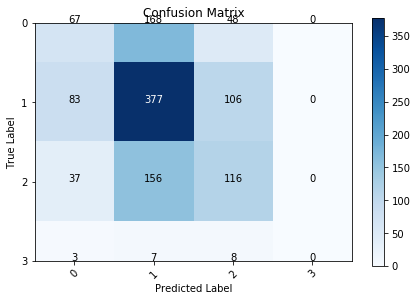

Plus 0.42962962962962964 Minus 0.3582887700534759
{'loss': 0.7794307123585499, 'val_loss': 1.1231091342815736, 'p_m': 0.23674911660777384, 'p_m_acc': 0.3582887700534759, 'p_p': 0.37540453074433655, 'p_p_acc': 0.42962962962962964, 'p_p_acc_2': 0.7073170731707317, 'p_m_acc_2': 0.6442307692307693}
Prediction for Y_4_0.0
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 133us/sample - loss: 1.2250 - accuracy: 0.4091 - val_loss: 1.1630 - val_accuracy: 0.4345
Epoch 2/5
2386/2386 [==============================] - 0s 119us/sample - loss: 0.9899 - accuracy: 0.5444 - val_loss: 1.1069 - val_accuracy: 0.4447
Epoch 3/5
2386/2386 [==============================] - 0s 122us/sample - loss: 0.8796 - accuracy: 0.6102 - val_loss: 1.1388 - val_accuracy: 0.4736
Epoch 4/5
2386/2386 [==============================] - 0s 121us/sample - loss: 0.8165 - accuracy: 0.6563 - val_loss: 1.1482 - val_accuracy: 0.4685
Epoch 5/5
2386/2386 [========================

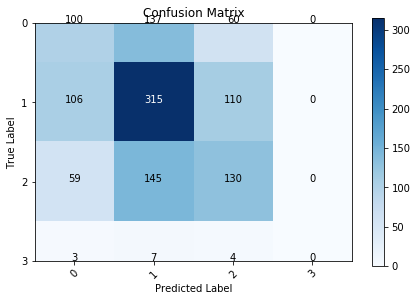

Plus 0.43333333333333335 Minus 0.37735849056603776
{'loss': 0.7585430922672115, 'val_loss': 1.1667330763777908, 'p_m': 0.3367003367003367, 'p_m_acc': 0.37735849056603776, 'p_p': 0.38922155688622756, 'p_p_acc': 0.43333333333333335, 'p_p_acc_2': 0.6842105263157895, 'p_m_acc_2': 0.6289308176100629}
Prediction for Y_5_0.0
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 136us/sample - loss: 1.2489 - accuracy: 0.4065 - val_loss: 1.1278 - val_accuracy: 0.4498
Epoch 2/5
2386/2386 [==============================] - 0s 116us/sample - loss: 0.9679 - accuracy: 0.5490 - val_loss: 1.1117 - val_accuracy: 0.4762
Epoch 3/5
2386/2386 [==============================] - 0s 130us/sample - loss: 0.8544 - accuracy: 0.6329 - val_loss: 1.1050 - val_accuracy: 0.4813
Epoch 4/5
2386/2386 [==============================] - 0s 136us/sample - loss: 0.7929 - accuracy: 0.6676 - val_loss: 1.1167 - val_accuracy: 0.4804
Epoch 5/5
2386/2386 [=======================

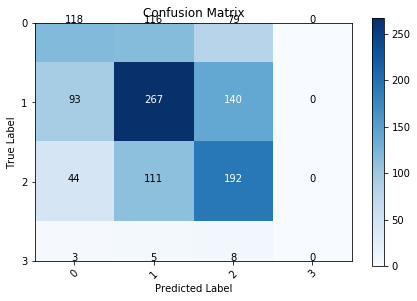

Plus 0.46715328467153283 Minus 0.4627450980392157
{'loss': 0.727934552707896, 'val_loss': 1.1095807159028086, 'p_m': 0.3769968051118211, 'p_m_acc': 0.4627450980392157, 'p_p': 0.553314121037464, 'p_p_acc': 0.46715328467153283, 'p_p_acc_2': 0.7084870848708487, 'p_m_acc_2': 0.7283950617283951}
Prediction for Y_1_0.5
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 152us/sample - loss: 0.7813 - accuracy: 0.7603 - val_loss: 0.7821 - val_accuracy: 0.7577
Epoch 2/5
2386/2386 [==============================] - 0s 132us/sample - loss: 0.6354 - accuracy: 0.7888 - val_loss: 0.7640 - val_accuracy: 0.7645
Epoch 3/5
2386/2386 [==============================] - 0s 128us/sample - loss: 0.5740 - accuracy: 0.7967 - val_loss: 0.7467 - val_accuracy: 0.7679
Epoch 4/5
2386/2386 [==============================] - 0s 145us/sample - loss: 0.5351 - accuracy: 0.8051 - val_loss: 0.7853 - val_accuracy: 0.7406
Epoch 5/5
2386/2386 [============================

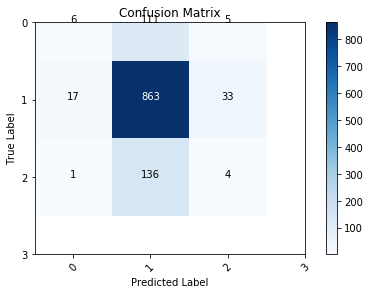

Plus 0.09523809523809523 Minus 0.25
{'loss': 0.49890256367704994, 'val_loss': 0.7806346035328041, 'p_m': 0.04918032786885246, 'p_m_acc': 0.25, 'p_p': 0.028368794326241134, 'p_p_acc': 0.09523809523809523, 'p_p_acc_2': 0.4444444444444444, 'p_m_acc_2': 0.8571428571428571}
Prediction for Y_2_0.5
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 120us/sample - loss: 0.9485 - accuracy: 0.6618 - val_loss: 0.8966 - val_accuracy: 0.6811
Epoch 2/5
2386/2386 [==============================] - 0s 120us/sample - loss: 0.7487 - accuracy: 0.7154 - val_loss: 0.8769 - val_accuracy: 0.6998
Epoch 3/5
2386/2386 [==============================] - 0s 192us/sample - loss: 0.6813 - accuracy: 0.7339 - val_loss: 0.8809 - val_accuracy: 0.6590
Epoch 4/5
2386/2386 [==============================] - 0s 118us/sample - loss: 0.6287 - accuracy: 0.7653 - val_loss: 0.8856 - val_accuracy: 0.6709
Epoch 5/5
2386/2386 [==============================] - 0s 119us/sample 

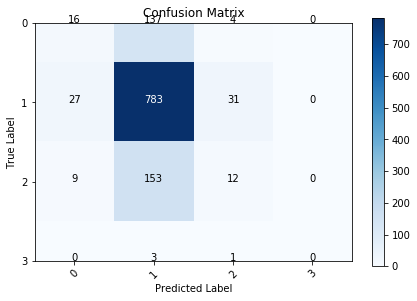

Plus 0.2553191489361702 Minus 0.3076923076923077
{'loss': 0.5732731979530795, 'val_loss': 0.8833983613520252, 'p_m': 0.10191082802547771, 'p_m_acc': 0.3076923076923077, 'p_p': 0.06896551724137931, 'p_p_acc': 0.2553191489361702, 'p_p_acc_2': 0.75, 'p_m_acc_2': 0.64}
Prediction for Y_3_0.5
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 160us/sample - loss: 1.0257 - accuracy: 0.6186 - val_loss: 0.9147 - val_accuracy: 0.6556
Epoch 2/5
2386/2386 [==============================] - 0s 146us/sample - loss: 0.7594 - accuracy: 0.6974 - val_loss: 0.8823 - val_accuracy: 0.6497
Epoch 3/5
2386/2386 [==============================] - 0s 121us/sample - loss: 0.6712 - accuracy: 0.7293 - val_loss: 0.9041 - val_accuracy: 0.6395
Epoch 4/5
2386/2386 [==============================] - 0s 122us/sample - loss: 0.6169 - accuracy: 0.7477 - val_loss: 0.8511 - val_accuracy: 0.6497
Epoch 5/5
2386/2386 [==============================] - 0s 118us/sample - lo

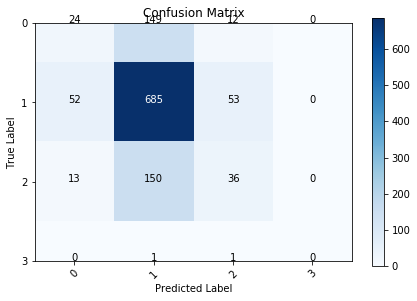

Plus 0.3564356435643564 Minus 0.2696629213483146
{'loss': 0.5741703612206868, 'val_loss': 0.86548789828813, 'p_m': 0.12972972972972974, 'p_m_acc': 0.2696629213483146, 'p_p': 0.18090452261306533, 'p_p_acc': 0.3564356435643564, 'p_p_acc_2': 0.75, 'p_m_acc_2': 0.6486486486486487}
Prediction for Y_4_0.5
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 122us/sample - loss: 1.0230 - accuracy: 0.6048 - val_loss: 0.9136 - val_accuracy: 0.6361
Epoch 2/5
2386/2386 [==============================] - 0s 132us/sample - loss: 0.7957 - accuracy: 0.6785 - val_loss: 0.8803 - val_accuracy: 0.6369
Epoch 3/5
2386/2386 [==============================] - 0s 121us/sample - loss: 0.6831 - accuracy: 0.7242 - val_loss: 0.8940 - val_accuracy: 0.6556
Epoch 4/5
2386/2386 [==============================] - 0s 119us/sample - loss: 0.6289 - accuracy: 0.7519 - val_loss: 0.9042 - val_accuracy: 0.6429
Epoch 5/5
2386/2386 [==============================] - 0s 118us

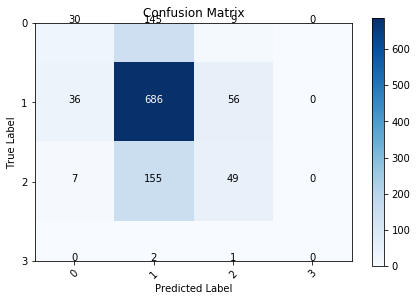

Plus 0.4298245614035088 Minus 0.410958904109589
{'loss': 0.579006721068108, 'val_loss': 0.8953408562407201, 'p_m': 0.16304347826086957, 'p_m_acc': 0.410958904109589, 'p_p': 0.23222748815165878, 'p_p_acc': 0.4298245614035088, 'p_p_acc_2': 0.8448275862068966, 'p_m_acc_2': 0.8108108108108109}
Prediction for Y_5_0.5
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 144us/sample - loss: 1.0111 - accuracy: 0.5935 - val_loss: 0.9160 - val_accuracy: 0.6148
Epoch 2/5
2386/2386 [==============================] - 0s 120us/sample - loss: 0.7823 - accuracy: 0.6744 - val_loss: 0.9288 - val_accuracy: 0.6241
Epoch 3/5
2386/2386 [==============================] - 0s 119us/sample - loss: 0.6798 - accuracy: 0.7146 - val_loss: 0.9158 - val_accuracy: 0.6318
Epoch 4/5
2386/2386 [==============================] - 0s 118us/sample - loss: 0.6230 - accuracy: 0.7410 - val_loss: 0.8995 - val_accuracy: 0.6454
Epoch 5/5
2386/2386 [=============================

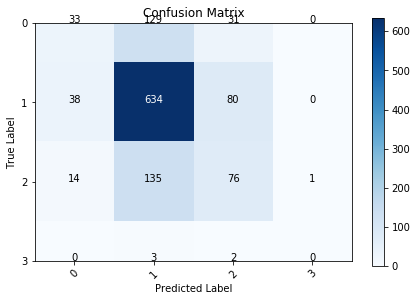

Plus 0.40641711229946526 Minus 0.38823529411764707
{'loss': 0.5865931566383094, 'val_loss': 0.9365356102281687, 'p_m': 0.17098445595854922, 'p_m_acc': 0.38823529411764707, 'p_p': 0.336283185840708, 'p_p_acc': 0.40641711229946526, 'p_p_acc_2': 0.7102803738317757, 'p_m_acc_2': 0.7021276595744681}
****Running: 2 ******
Prediction for Y_1_0.0
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 185us/sample - loss: 1.0861 - accuracy: 0.5549 - val_loss: 1.0645 - val_accuracy: 0.5145
Epoch 2/5
2386/2386 [==============================] - 0s 119us/sample - loss: 0.8772 - accuracy: 0.6174 - val_loss: 1.0002 - val_accuracy: 0.5850
Epoch 3/5
2386/2386 [==============================] - 0s 120us/sample - loss: 0.7979 - accuracy: 0.6542 - val_loss: 1.0416 - val_accuracy: 0.5689
Epoch 4/5
2386/2386 [==============================] - 0s 119us/sample - loss: 0.7514 - accuracy: 0.6832 - val_loss: 1.0662 - val_accuracy: 0.5740
Epoch 5/5
2386/2386 [==

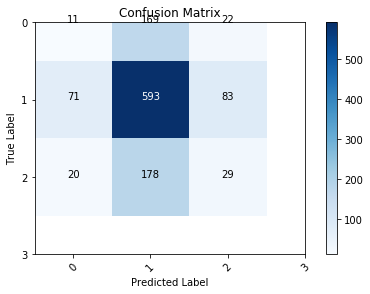

Plus 0.21641791044776118 Minus 0.10784313725490197
{'loss': 0.723666169167764, 'val_loss': 1.0713962657111031, 'p_m': 0.054455445544554455, 'p_m_acc': 0.10784313725490197, 'p_p': 0.1277533039647577, 'p_p_acc': 0.21641791044776118, 'p_p_acc_2': 0.5686274509803921, 'p_m_acc_2': 0.3548387096774194}
Prediction for Y_2_0.0
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 133us/sample - loss: 1.1900 - accuracy: 0.4719 - val_loss: 1.1037 - val_accuracy: 0.4949
Epoch 2/5
2386/2386 [==============================] - 0s 119us/sample - loss: 0.9732 - accuracy: 0.5608 - val_loss: 1.0984 - val_accuracy: 0.5213
Epoch 3/5
2386/2386 [==============================] - 0s 122us/sample - loss: 0.8860 - accuracy: 0.6069 - val_loss: 1.1026 - val_accuracy: 0.5102
Epoch 4/5
2386/2386 [==============================] - 0s 118us/sample - loss: 0.8298 - accuracy: 0.6479 - val_loss: 1.0969 - val_accuracy: 0.5153
Epoch 5/5
2386/2386 [=======================

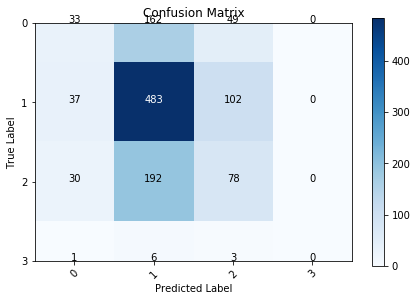

Plus 0.3406113537117904 Minus 0.33
{'loss': 0.7839625438820487, 'val_loss': 1.119866521991029, 'p_m': 0.13524590163934427, 'p_m_acc': 0.33, 'p_p': 0.26, 'p_p_acc': 0.3406113537117904, 'p_p_acc_2': 0.6141732283464567, 'p_m_acc_2': 0.5238095238095238}
Prediction for Y_3_0.0
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 175us/sample - loss: 1.2616 - accuracy: 0.4116 - val_loss: 1.1544 - val_accuracy: 0.4651
Epoch 2/5
2386/2386 [==============================] - 0s 123us/sample - loss: 0.9973 - accuracy: 0.5469 - val_loss: 1.1146 - val_accuracy: 0.4940
Epoch 3/5
2386/2386 [==============================] - 0s 120us/sample - loss: 0.8982 - accuracy: 0.5897 - val_loss: 1.1479 - val_accuracy: 0.4762
Epoch 4/5
2386/2386 [==============================] - 0s 126us/sample - loss: 0.8283 - accuracy: 0.6438 - val_loss: 1.1237 - val_accuracy: 0.4966
Epoch 5/5
2386/2386 [==============================] - 0s 127us/sample - loss: 0.7853 - acc

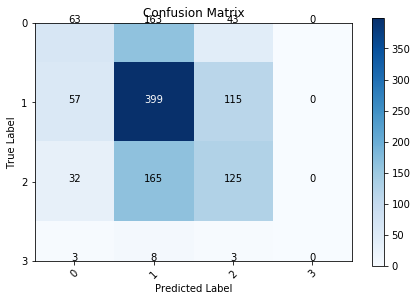

Plus 0.4416961130742049 Minus 0.4144736842105263
{'loss': 0.785308397126018, 'val_loss': 1.103115939769615, 'p_m': 0.2342007434944238, 'p_m_acc': 0.4144736842105263, 'p_p': 0.38819875776397517, 'p_p_acc': 0.4416961130742049, 'p_p_acc_2': 0.7440476190476191, 'p_m_acc_2': 0.6631578947368421}
Prediction for Y_4_0.0
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 152us/sample - loss: 1.2484 - accuracy: 0.4028 - val_loss: 1.1260 - val_accuracy: 0.4464
Epoch 2/5
2386/2386 [==============================] - 0s 121us/sample - loss: 1.0125 - accuracy: 0.5323 - val_loss: 1.0780 - val_accuracy: 0.4685
Epoch 3/5
2386/2386 [==============================] - 0s 134us/sample - loss: 0.9200 - accuracy: 0.5759 - val_loss: 1.1082 - val_accuracy: 0.4796
Epoch 4/5
2386/2386 [==============================] - 0s 140us/sample - loss: 0.8487 - accuracy: 0.6320 - val_loss: 1.0970 - val_accuracy: 0.4685
Epoch 5/5
2386/2386 [=============================

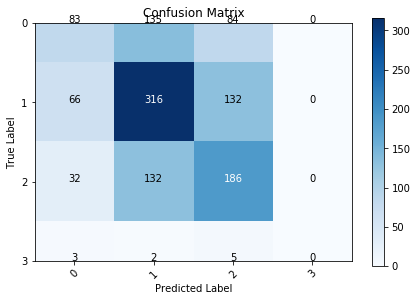

Plus 0.4626865671641791 Minus 0.4585635359116022
{'loss': 0.8038490725882596, 'val_loss': 1.097362142841832, 'p_m': 0.27483443708609273, 'p_m_acc': 0.4585635359116022, 'p_p': 0.5314285714285715, 'p_p_acc': 0.4626865671641791, 'p_p_acc_2': 0.6888888888888889, 'p_m_acc_2': 0.7217391304347827}
Prediction for Y_5_0.0
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 120us/sample - loss: 1.2358 - accuracy: 0.4191 - val_loss: 1.1115 - val_accuracy: 0.4609
Epoch 2/5
2386/2386 [==============================] - 0s 119us/sample - loss: 0.9824 - accuracy: 0.5482 - val_loss: 1.0876 - val_accuracy: 0.4974
Epoch 3/5
2386/2386 [==============================] - 0s 121us/sample - loss: 0.8851 - accuracy: 0.6098 - val_loss: 1.0549 - val_accuracy: 0.5085
Epoch 4/5
2386/2386 [==============================] - 0s 136us/sample - loss: 0.8054 - accuracy: 0.6509 - val_loss: 1.0732 - val_accuracy: 0.5094
Epoch 5/5
2386/2386 [============================

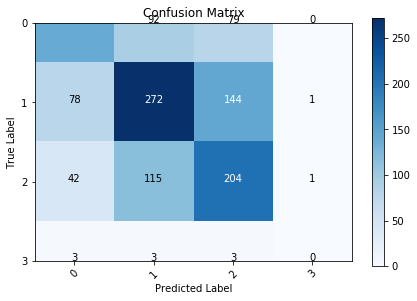

Plus 0.477751756440281 Minus 0.5366795366795367
{'loss': 0.7423557021591909, 'val_loss': 1.060223398565435, 'p_m': 0.4483870967741935, 'p_m_acc': 0.5366795366795367, 'p_p': 0.56353591160221, 'p_p_acc': 0.477751756440281, 'p_p_acc_2': 0.7208480565371025, 'p_m_acc_2': 0.7679558011049724}
Prediction for Y_1_0.5
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 140us/sample - loss: 0.8739 - accuracy: 0.7251 - val_loss: 0.7409 - val_accuracy: 0.7925
Epoch 2/5
2386/2386 [==============================] - 0s 140us/sample - loss: 0.6559 - accuracy: 0.7766 - val_loss: 0.7328 - val_accuracy: 0.7713
Epoch 3/5
2386/2386 [==============================] - 0s 167us/sample - loss: 0.5998 - accuracy: 0.7850 - val_loss: 0.7125 - val_accuracy: 0.7959
Epoch 4/5
2386/2386 [==============================] - 0s 119us/sample - loss: 0.5586 - accuracy: 0.7972 - val_loss: 0.7112 - val_accuracy: 0.7942
Epoch 5/5
2386/2386 [==============================] -

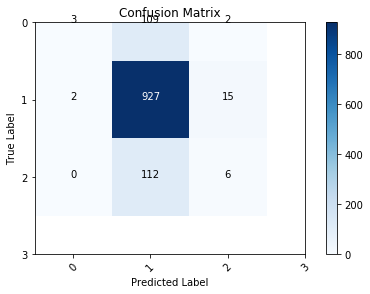

Plus 0.2608695652173913 Minus 0.6
{'loss': 0.5124272633178436, 'val_loss': 0.7329899903868331, 'p_m': 0.02631578947368421, 'p_m_acc': 0.6, 'p_p': 0.05084745762711865, 'p_p_acc': 0.2608695652173913, 'p_p_acc_2': 0.75, 'p_m_acc_2': 1.0}
Prediction for Y_2_0.5
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 130us/sample - loss: 0.9387 - accuracy: 0.6626 - val_loss: 0.9074 - val_accuracy: 0.6726
Epoch 2/5
2386/2386 [==============================] - 0s 138us/sample - loss: 0.7603 - accuracy: 0.7121 - val_loss: 0.8770 - val_accuracy: 0.6565
Epoch 3/5
2386/2386 [==============================] - 0s 140us/sample - loss: 0.6717 - accuracy: 0.7435 - val_loss: 0.8953 - val_accuracy: 0.7015
Epoch 4/5
2386/2386 [==============================] - 0s 132us/sample - loss: 0.6371 - accuracy: 0.7510 - val_loss: 0.8860 - val_accuracy: 0.6667
Epoch 5/5
2386/2386 [==============================] - 0s 138us/sample - loss: 0.5877 - accuracy: 0.7699 -

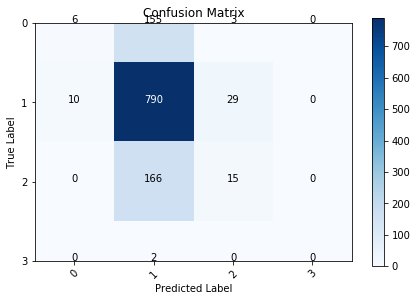

Plus 0.3191489361702128 Minus 0.375
{'loss': 0.5876983227294129, 'val_loss': 0.8842968194663119, 'p_m': 0.036585365853658534, 'p_m_acc': 0.375, 'p_p': 0.08287292817679558, 'p_p_acc': 0.3191489361702128, 'p_p_acc_2': 0.8333333333333334, 'p_m_acc_2': 1.0}
Prediction for Y_3_0.5
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 125us/sample - loss: 1.0119 - accuracy: 0.6140 - val_loss: 0.9760 - val_accuracy: 0.6718
Epoch 2/5
2386/2386 [==============================] - 0s 154us/sample - loss: 0.7750 - accuracy: 0.6819 - val_loss: 0.9108 - val_accuracy: 0.6675
Epoch 3/5
2386/2386 [==============================] - 0s 117us/sample - loss: 0.6830 - accuracy: 0.7221 - val_loss: 0.8933 - val_accuracy: 0.6616
Epoch 4/5
2386/2386 [==============================] - 0s 115us/sample - loss: 0.6118 - accuracy: 0.7544 - val_loss: 0.8951 - val_accuracy: 0.6395
Epoch 5/5
2386/2386 [==============================] - 0s 132us/sample - loss: 0.5700 -

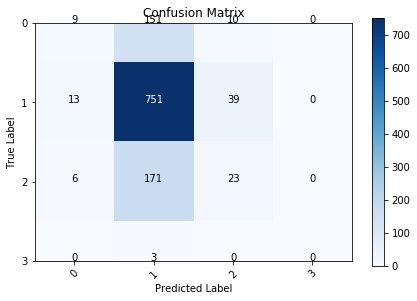

Plus 0.3194444444444444 Minus 0.32142857142857145
{'loss': 0.5700307635329696, 'val_loss': 0.9091115407392282, 'p_m': 0.052941176470588235, 'p_m_acc': 0.32142857142857145, 'p_p': 0.115, 'p_p_acc': 0.3194444444444444, 'p_p_acc_2': 0.696969696969697, 'p_m_acc_2': 0.6}
Prediction for Y_4_0.5
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 116us/sample - loss: 1.0549 - accuracy: 0.5821 - val_loss: 0.9190 - val_accuracy: 0.6403
Epoch 2/5
2386/2386 [==============================] - 0s 145us/sample - loss: 0.7905 - accuracy: 0.6714 - val_loss: 0.8801 - val_accuracy: 0.6650
Epoch 3/5
2386/2386 [==============================] - 0s 116us/sample - loss: 0.7080 - accuracy: 0.7070 - val_loss: 0.8705 - val_accuracy: 0.6650
Epoch 4/5
2386/2386 [==============================] - 0s 117us/sample - loss: 0.6566 - accuracy: 0.7305 - val_loss: 0.8402 - val_accuracy: 0.6650
Epoch 5/5
2386/2386 [==============================] - 0s 124us/sample - l

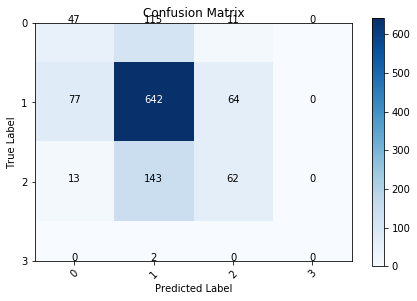

Plus 0.45255474452554745 Minus 0.34306569343065696
{'loss': 0.6054471271535676, 'val_loss': 0.900890418461391, 'p_m': 0.27167630057803466, 'p_m_acc': 0.34306569343065696, 'p_p': 0.28440366972477066, 'p_p_acc': 0.45255474452554745, 'p_p_acc_2': 0.8493150684931506, 'p_m_acc_2': 0.7833333333333333}
Prediction for Y_5_0.5
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 117us/sample - loss: 1.0440 - accuracy: 0.5838 - val_loss: 0.8909 - val_accuracy: 0.6412
Epoch 2/5
2386/2386 [==============================] - 0s 128us/sample - loss: 0.7931 - accuracy: 0.6731 - val_loss: 0.8962 - val_accuracy: 0.6539
Epoch 3/5
2386/2386 [==============================] - 0s 116us/sample - loss: 0.7032 - accuracy: 0.7079 - val_loss: 0.8663 - val_accuracy: 0.6599
Epoch 4/5
2386/2386 [==============================] - 0s 116us/sample - loss: 0.6359 - accuracy: 0.7397 - val_loss: 0.8524 - val_accuracy: 0.6403
Epoch 5/5
2386/2386 [=======================

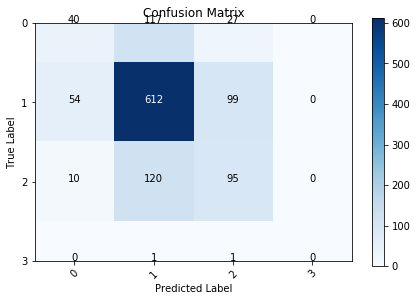

Plus 0.4298642533936652 Minus 0.38461538461538464
{'loss': 0.5872745290585956, 'val_loss': 0.8797507026568562, 'p_m': 0.21739130434782608, 'p_m_acc': 0.38461538461538464, 'p_p': 0.4222222222222222, 'p_p_acc': 0.4298642533936652, 'p_p_acc_2': 0.7786885245901639, 'p_m_acc_2': 0.8}
****Running: 3 ******
Prediction for Y_1_0.0
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 202us/sample - loss: 1.0544 - accuracy: 0.5650 - val_loss: 1.0382 - val_accuracy: 0.5468
Epoch 2/5
2386/2386 [==============================] - 0s 133us/sample - loss: 0.8989 - accuracy: 0.6262 - val_loss: 1.0199 - val_accuracy: 0.5544
Epoch 3/5
2386/2386 [==============================] - 0s 122us/sample - loss: 0.8099 - accuracy: 0.6630 - val_loss: 1.0233 - val_accuracy: 0.5799
Epoch 4/5
2386/2386 [==============================] - 0s 127us/sample - loss: 0.7483 - accuracy: 0.6903 - val_loss: 1.0303 - val_accuracy: 0.5646
Epoch 5/5
2386/2386 [==================

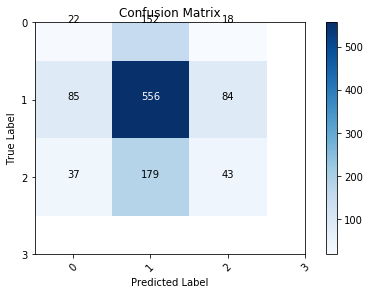

Plus 0.296551724137931 Minus 0.1527777777777778
{'loss': 0.6999225552503741, 'val_loss': 1.088579924739137, 'p_m': 0.11458333333333333, 'p_m_acc': 0.1527777777777778, 'p_p': 0.16602316602316602, 'p_p_acc': 0.296551724137931, 'p_p_acc_2': 0.7049180327868853, 'p_m_acc_2': 0.3728813559322034}
Prediction for Y_2_0.0
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 142us/sample - loss: 1.2407 - accuracy: 0.4531 - val_loss: 1.1533 - val_accuracy: 0.4541
Epoch 2/5
2386/2386 [==============================] - 0s 122us/sample - loss: 0.9686 - accuracy: 0.5683 - val_loss: 1.0994 - val_accuracy: 0.4762
Epoch 3/5
2386/2386 [==============================] - 0s 118us/sample - loss: 0.8756 - accuracy: 0.6190 - val_loss: 1.1147 - val_accuracy: 0.4515
Epoch 4/5
2386/2386 [==============================] - 0s 125us/sample - loss: 0.8156 - accuracy: 0.6505 - val_loss: 1.0969 - val_accuracy: 0.4736
Epoch 5/5
2386/2386 [=============================

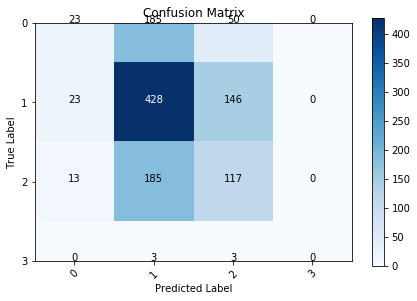

Plus 0.3738019169329074 Minus 0.3898305084745763
{'loss': 0.7766347321160981, 'val_loss': 1.0995929808843703, 'p_m': 0.08914728682170543, 'p_m_acc': 0.3898305084745763, 'p_p': 0.37142857142857144, 'p_p_acc': 0.3738019169329074, 'p_p_acc_2': 0.7005988023952096, 'p_m_acc_2': 0.6388888888888888}
Prediction for Y_3_0.0
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 153us/sample - loss: 1.2304 - accuracy: 0.4409 - val_loss: 1.1954 - val_accuracy: 0.4320
Epoch 2/5
2386/2386 [==============================] - 0s 116us/sample - loss: 1.0067 - accuracy: 0.5478 - val_loss: 1.1467 - val_accuracy: 0.4592
Epoch 3/5
2386/2386 [==============================] - 0s 116us/sample - loss: 0.9081 - accuracy: 0.6031 - val_loss: 1.1190 - val_accuracy: 0.4634
Epoch 4/5
2386/2386 [==============================] - 0s 115us/sample - loss: 0.8248 - accuracy: 0.6475 - val_loss: 1.0986 - val_accuracy: 0.4804
Epoch 5/5
2386/2386 [==========================

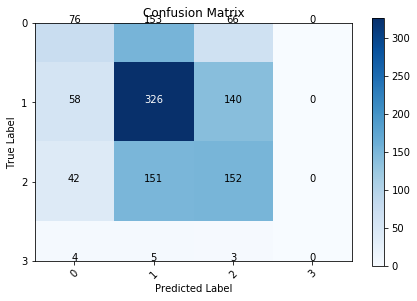

Plus 0.4245810055865922 Minus 0.4318181818181818
{'loss': 0.7641793222659192, 'val_loss': 1.1162648055018212, 'p_m': 0.2576271186440678, 'p_m_acc': 0.4318181818181818, 'p_p': 0.4405797101449275, 'p_p_acc': 0.4245810055865922, 'p_p_acc_2': 0.6972477064220184, 'p_m_acc_2': 0.6440677966101694}
Prediction for Y_4_0.0
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 127us/sample - loss: 1.2604 - accuracy: 0.4007 - val_loss: 1.2445 - val_accuracy: 0.4337
Epoch 2/5
2386/2386 [==============================] - 0s 115us/sample - loss: 0.9932 - accuracy: 0.5545 - val_loss: 1.1235 - val_accuracy: 0.4464
Epoch 3/5
2386/2386 [==============================] - 0s 116us/sample - loss: 0.8914 - accuracy: 0.6127 - val_loss: 1.0883 - val_accuracy: 0.4898
Epoch 4/5
2386/2386 [==============================] - 0s 114us/sample - loss: 0.8228 - accuracy: 0.6559 - val_loss: 1.1079 - val_accuracy: 0.4719
Epoch 5/5
2386/2386 [============================

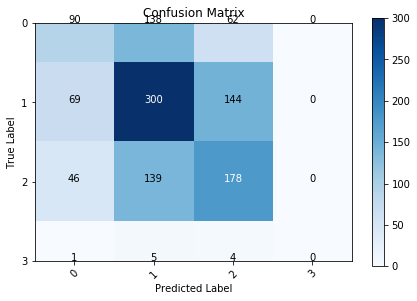

Plus 0.4635416666666667 Minus 0.43902439024390244
{'loss': 0.7680227170446193, 'val_loss': 1.120125920594144, 'p_m': 0.3103448275862069, 'p_m_acc': 0.43902439024390244, 'p_p': 0.4903581267217631, 'p_p_acc': 0.4635416666666667, 'p_p_acc_2': 0.7416666666666667, 'p_m_acc_2': 0.6617647058823529}
Prediction for Y_5_0.0
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 129us/sample - loss: 1.1955 - accuracy: 0.4401 - val_loss: 1.1330 - val_accuracy: 0.4422
Epoch 2/5
2386/2386 [==============================] - 0s 115us/sample - loss: 0.9755 - accuracy: 0.5545 - val_loss: 1.0785 - val_accuracy: 0.4855
Epoch 3/5
2386/2386 [==============================] - 0s 115us/sample - loss: 0.8628 - accuracy: 0.6375 - val_loss: 1.0965 - val_accuracy: 0.4889
Epoch 4/5
2386/2386 [==============================] - 0s 116us/sample - loss: 0.8068 - accuracy: 0.6710 - val_loss: 1.1714 - val_accuracy: 0.4813
Epoch 5/5
2386/2386 [===========================

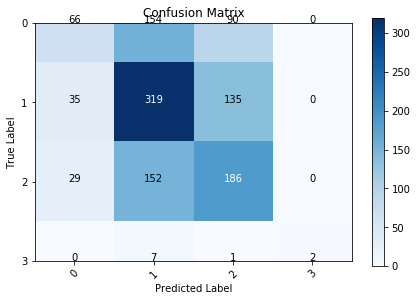

Plus 0.45255474452554745 Minus 0.5076923076923077
{'loss': 0.7455088651090336, 'val_loss': 1.131150796299889, 'p_m': 0.2129032258064516, 'p_m_acc': 0.5076923076923077, 'p_p': 0.5068119891008175, 'p_p_acc': 0.45255474452554745, 'p_p_acc_2': 0.6739130434782609, 'p_m_acc_2': 0.6947368421052632}
Prediction for Y_1_0.5
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 136us/sample - loss: 0.8307 - accuracy: 0.7347 - val_loss: 0.7790 - val_accuracy: 0.7398
Epoch 2/5
2386/2386 [==============================] - 0s 128us/sample - loss: 0.6326 - accuracy: 0.7921 - val_loss: 0.7869 - val_accuracy: 0.7304
Epoch 3/5
2386/2386 [==============================] - 0s 127us/sample - loss: 0.5591 - accuracy: 0.8051 - val_loss: 0.7684 - val_accuracy: 0.7517
Epoch 4/5
2386/2386 [==============================] - 0s 148us/sample - loss: 0.5211 - accuracy: 0.8127 - val_loss: 0.7894 - val_accuracy: 0.7636
Epoch 5/5
2386/2386 [===========================

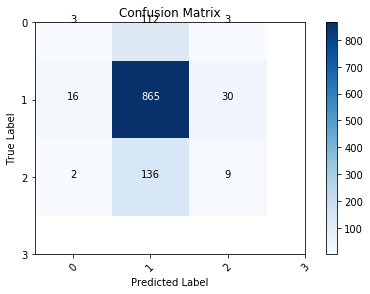

Plus 0.21428571428571427 Minus 0.14285714285714285
{'loss': 0.4856730864413726, 'val_loss': 0.7756209219394087, 'p_m': 0.025423728813559324, 'p_m_acc': 0.14285714285714285, 'p_p': 0.061224489795918366, 'p_p_acc': 0.21428571428571427, 'p_p_acc_2': 0.75, 'p_m_acc_2': 0.6}
Prediction for Y_2_0.5
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 155us/sample - loss: 0.9275 - accuracy: 0.6744 - val_loss: 0.9160 - val_accuracy: 0.6658
Epoch 2/5
2386/2386 [==============================] - 0s 129us/sample - loss: 0.7455 - accuracy: 0.7259 - val_loss: 0.9065 - val_accuracy: 0.6378
Epoch 3/5
2386/2386 [==============================] - 0s 127us/sample - loss: 0.6706 - accuracy: 0.7473 - val_loss: 0.8863 - val_accuracy: 0.6539
Epoch 4/5
2386/2386 [==============================] - 0s 148us/sample - loss: 0.6105 - accuracy: 0.7640 - val_loss: 0.9289 - val_accuracy: 0.6412
Epoch 5/5
2386/2386 [==============================] - 0s 132us/sample

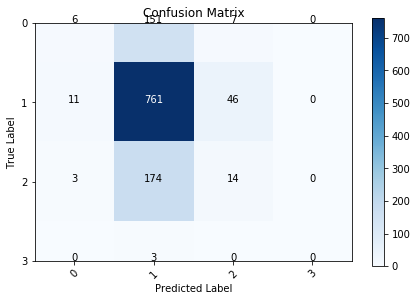

Plus 0.208955223880597 Minus 0.3
{'loss': 0.5846512989146512, 'val_loss': 0.9125996163102235, 'p_m': 0.036585365853658534, 'p_m_acc': 0.3, 'p_p': 0.07329842931937172, 'p_p_acc': 0.208955223880597, 'p_p_acc_2': 0.6666666666666666, 'p_m_acc_2': 0.6666666666666666}
Prediction for Y_3_0.5
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 122us/sample - loss: 0.9892 - accuracy: 0.6253 - val_loss: 0.8949 - val_accuracy: 0.6395
Epoch 2/5
2386/2386 [==============================] - 0s 128us/sample - loss: 0.7583 - accuracy: 0.7058 - val_loss: 0.8610 - val_accuracy: 0.6514
Epoch 3/5
2386/2386 [==============================] - 0s 120us/sample - loss: 0.6884 - accuracy: 0.7326 - val_loss: 0.8886 - val_accuracy: 0.6420
Epoch 4/5
2386/2386 [==============================] - 0s 133us/sample - loss: 0.6302 - accuracy: 0.7582 - val_loss: 0.8650 - val_accuracy: 0.6522
Epoch 5/5
2386/2386 [==============================] - 0s 115us/sample - loss:

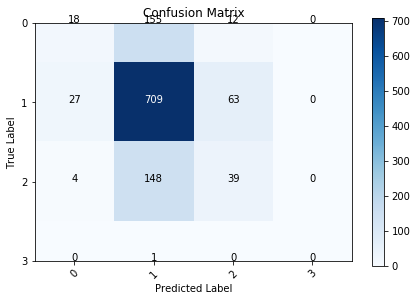

Plus 0.34210526315789475 Minus 0.3673469387755102
{'loss': 0.5822490043032599, 'val_loss': 0.8455642368517765, 'p_m': 0.0972972972972973, 'p_m_acc': 0.3673469387755102, 'p_p': 0.20418848167539266, 'p_p_acc': 0.34210526315789475, 'p_p_acc_2': 0.7647058823529411, 'p_m_acc_2': 0.8181818181818182}
Prediction for Y_4_0.5
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 133us/sample - loss: 1.0027 - accuracy: 0.6085 - val_loss: 0.9441 - val_accuracy: 0.6088
Epoch 2/5
2386/2386 [==============================] - 0s 135us/sample - loss: 0.7663 - accuracy: 0.6852 - val_loss: 0.8980 - val_accuracy: 0.6216
Epoch 3/5
2386/2386 [==============================] - 0s 142us/sample - loss: 0.6778 - accuracy: 0.7188 - val_loss: 0.9081 - val_accuracy: 0.6437
Epoch 4/5
2386/2386 [==============================] - 0s 115us/sample - loss: 0.6115 - accuracy: 0.7687 - val_loss: 0.8835 - val_accuracy: 0.6250
Epoch 5/5
2386/2386 [=========================

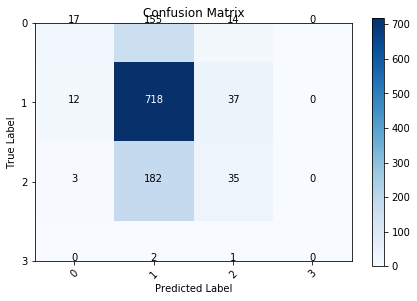

Plus 0.4069767441860465 Minus 0.53125
{'loss': 0.569192684156397, 'val_loss': 0.8859392372118372, 'p_m': 0.0913978494623656, 'p_m_acc': 0.53125, 'p_p': 0.1590909090909091, 'p_p_acc': 0.4069767441860465, 'p_p_acc_2': 0.7142857142857143, 'p_m_acc_2': 0.85}
Prediction for Y_5_0.5
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 1s 225us/sample - loss: 1.0467 - accuracy: 0.5821 - val_loss: 0.9181 - val_accuracy: 0.6250
Epoch 2/5
2386/2386 [==============================] - 0s 112us/sample - loss: 0.7668 - accuracy: 0.6882 - val_loss: 0.8952 - val_accuracy: 0.6284
Epoch 3/5
2386/2386 [==============================] - 0s 117us/sample - loss: 0.6763 - accuracy: 0.7209 - val_loss: 0.9129 - val_accuracy: 0.6241
Epoch 4/5
2386/2386 [==============================] - 0s 114us/sample - loss: 0.6160 - accuracy: 0.7548 - val_loss: 0.8998 - val_accuracy: 0.6190
Epoch 5/5
2386/2386 [==============================] - 0s 159us/sample - loss: 0.5632 

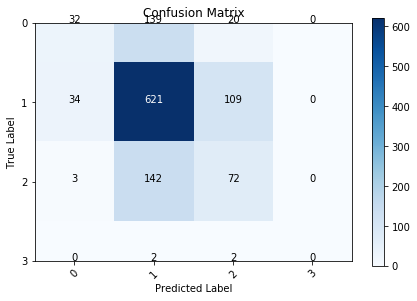

Plus 0.3582089552238806 Minus 0.463768115942029
{'loss': 0.5632311490435412, 'val_loss': 0.9098925509420382, 'p_m': 0.16753926701570682, 'p_m_acc': 0.463768115942029, 'p_p': 0.3317972350230415, 'p_p_acc': 0.3582089552238806, 'p_p_acc_2': 0.782608695652174, 'p_m_acc_2': 0.9142857142857143}
****Running: 4 ******
Prediction for Y_1_0.0
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 172us/sample - loss: 1.1192 - accuracy: 0.5423 - val_loss: 1.0471 - val_accuracy: 0.5995
Epoch 2/5
2386/2386 [==============================] - 0s 130us/sample - loss: 0.8918 - accuracy: 0.6241 - val_loss: 1.0032 - val_accuracy: 0.6037
Epoch 3/5
2386/2386 [==============================] - 0s 121us/sample - loss: 0.8125 - accuracy: 0.6521 - val_loss: 1.0041 - val_accuracy: 0.5791
Epoch 4/5
2386/2386 [==============================] - 0s 127us/sample - loss: 0.7731 - accuracy: 0.6840 - val_loss: 1.0282 - val_accuracy: 0.5910
Epoch 5/5
2386/2386 [========

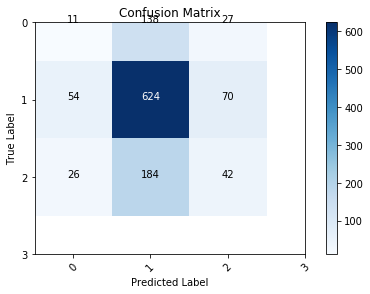

Plus 0.302158273381295 Minus 0.12087912087912088
{'loss': 0.7175781083826447, 'val_loss': 1.025987516049625, 'p_m': 0.0625, 'p_m_acc': 0.12087912087912088, 'p_p': 0.16666666666666666, 'p_p_acc': 0.302158273381295, 'p_p_acc_2': 0.6086956521739131, 'p_m_acc_2': 0.2972972972972973}
Prediction for Y_2_0.0
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 148us/sample - loss: 1.1911 - accuracy: 0.4514 - val_loss: 1.1487 - val_accuracy: 0.4966
Epoch 2/5
2386/2386 [==============================] - 0s 116us/sample - loss: 0.9805 - accuracy: 0.5608 - val_loss: 1.0898 - val_accuracy: 0.4711
Epoch 3/5
2386/2386 [==============================] - 0s 125us/sample - loss: 0.8659 - accuracy: 0.6165 - val_loss: 1.0866 - val_accuracy: 0.4728
Epoch 4/5
2386/2386 [==============================] - 0s 128us/sample - loss: 0.8091 - accuracy: 0.6454 - val_loss: 1.0738 - val_accuracy: 0.5145
Epoch 5/5
2386/2386 [==============================] - 0s 115

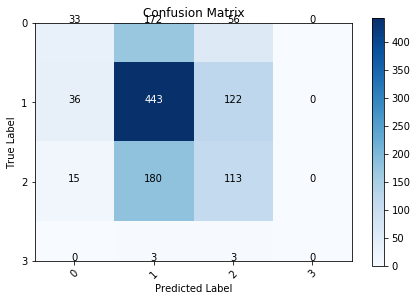

Plus 0.38831615120274915 Minus 0.39285714285714285
{'loss': 0.7631083028914043, 'val_loss': 1.149022326582954, 'p_m': 0.12643678160919541, 'p_m_acc': 0.39285714285714285, 'p_p': 0.36688311688311687, 'p_p_acc': 0.38831615120274915, 'p_p_acc_2': 0.6686390532544378, 'p_m_acc_2': 0.6875}
Prediction for Y_3_0.0
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 149us/sample - loss: 1.2236 - accuracy: 0.4380 - val_loss: 1.1641 - val_accuracy: 0.4677
Epoch 2/5
2386/2386 [==============================] - 0s 131us/sample - loss: 1.0089 - accuracy: 0.5419 - val_loss: 1.1238 - val_accuracy: 0.4974
Epoch 3/5
2386/2386 [==============================] - 0s 128us/sample - loss: 0.9015 - accuracy: 0.5968 - val_loss: 1.1229 - val_accuracy: 0.4813
Epoch 4/5
2386/2386 [==============================] - 0s 127us/sample - loss: 0.8265 - accuracy: 0.6475 - val_loss: 1.1151 - val_accuracy: 0.4881
Epoch 5/5
2386/2386 [==============================] - 0

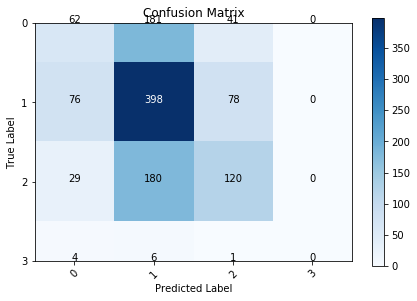

Plus 0.502092050209205 Minus 0.3712574850299401
{'loss': 0.7777284781970802, 'val_loss': 1.1284484169921096, 'p_m': 0.21830985915492956, 'p_m_acc': 0.3712574850299401, 'p_p': 0.364741641337386, 'p_p_acc': 0.502092050209205, 'p_p_acc_2': 0.7453416149068323, 'p_m_acc_2': 0.6813186813186813}
Prediction for Y_4_0.0
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 124us/sample - loss: 1.2247 - accuracy: 0.4258 - val_loss: 1.1959 - val_accuracy: 0.4031
Epoch 2/5
2386/2386 [==============================] - 0s 120us/sample - loss: 0.9859 - accuracy: 0.5503 - val_loss: 1.1667 - val_accuracy: 0.4515
Epoch 3/5
2386/2386 [==============================] - 0s 115us/sample - loss: 0.8834 - accuracy: 0.6207 - val_loss: 1.1292 - val_accuracy: 0.4864
Epoch 4/5
2386/2386 [==============================] - 0s 134us/sample - loss: 0.8130 - accuracy: 0.6635 - val_loss: 1.1111 - val_accuracy: 0.4830
Epoch 5/5
2386/2386 [==============================

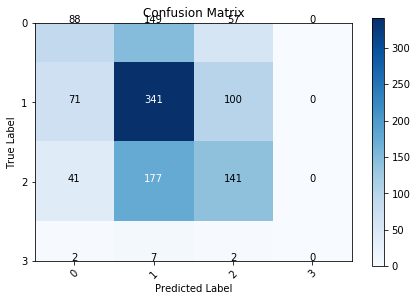

Plus 0.47315436241610737 Minus 0.44
{'loss': 0.7547408041090697, 'val_loss': 1.1324882264039955, 'p_m': 0.29931972789115646, 'p_m_acc': 0.44, 'p_p': 0.39275766016713093, 'p_p_acc': 0.47315436241610737, 'p_p_acc_2': 0.7121212121212122, 'p_m_acc_2': 0.6821705426356589}
Prediction for Y_5_0.0
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 117us/sample - loss: 1.2290 - accuracy: 0.4179 - val_loss: 1.1562 - val_accuracy: 0.4388
Epoch 2/5
2386/2386 [==============================] - 0s 114us/sample - loss: 0.9780 - accuracy: 0.5553 - val_loss: 1.0749 - val_accuracy: 0.4872
Epoch 3/5
2386/2386 [==============================] - 0s 115us/sample - loss: 0.8718 - accuracy: 0.6241 - val_loss: 1.0895 - val_accuracy: 0.5111
Epoch 4/5
2386/2386 [==============================] - 0s 127us/sample - loss: 0.8078 - accuracy: 0.6597 - val_loss: 1.1160 - val_accuracy: 0.5026
Epoch 5/5
2386/2386 [==============================] - 0s 114us/sample - 

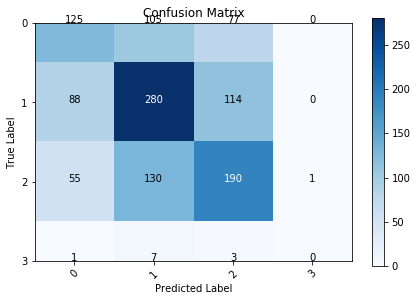

Plus 0.49868766404199477 Minus 0.4664179104477612
{'loss': 0.7519831659408147, 'val_loss': 1.0792082008861361, 'p_m': 0.40716612377850164, 'p_m_acc': 0.4664179104477612, 'p_p': 0.5053191489361702, 'p_p_acc': 0.49868766404199477, 'p_p_acc_2': 0.7116104868913857, 'p_m_acc_2': 0.6944444444444444}
Prediction for Y_1_0.5
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 140us/sample - loss: 0.8806 - accuracy: 0.7200 - val_loss: 0.7355 - val_accuracy: 0.7772
Epoch 2/5
2386/2386 [==============================] - 0s 142us/sample - loss: 0.6484 - accuracy: 0.7863 - val_loss: 0.7275 - val_accuracy: 0.7781
Epoch 3/5
2386/2386 [==============================] - 0s 143us/sample - loss: 0.5800 - accuracy: 0.7934 - val_loss: 0.7342 - val_accuracy: 0.7832
Epoch 4/5
2386/2386 [==============================] - 0s 115us/sample - loss: 0.5463 - accuracy: 0.8026 - val_loss: 0.7402 - val_accuracy: 0.7602
Epoch 5/5
2386/2386 [=========================

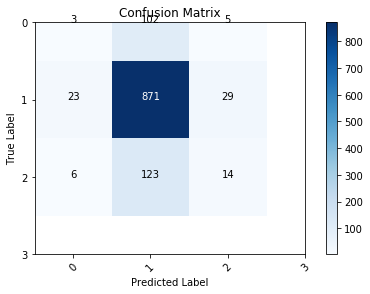

Plus 0.2916666666666667 Minus 0.09375
{'loss': 0.4999026823523458, 'val_loss': 0.7653657258773336, 'p_m': 0.02727272727272727, 'p_m_acc': 0.09375, 'p_p': 0.0979020979020979, 'p_p_acc': 0.2916666666666667, 'p_p_acc_2': 0.7368421052631579, 'p_m_acc_2': 0.3333333333333333}
Prediction for Y_2_0.5
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 119us/sample - loss: 0.9495 - accuracy: 0.6718 - val_loss: 0.8936 - val_accuracy: 0.6922
Epoch 2/5
2386/2386 [==============================] - 0s 114us/sample - loss: 0.7243 - accuracy: 0.7305 - val_loss: 0.8787 - val_accuracy: 0.6820
Epoch 3/5
2386/2386 [==============================] - 0s 122us/sample - loss: 0.6604 - accuracy: 0.7552 - val_loss: 0.9183 - val_accuracy: 0.6573
Epoch 4/5
2386/2386 [==============================] - 0s 116us/sample - loss: 0.6076 - accuracy: 0.7649 - val_loss: 0.9226 - val_accuracy: 0.6743
Epoch 5/5
2386/2386 [==============================] - 0s 115us/sample

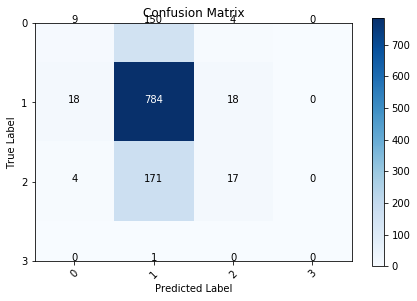

Plus 0.4358974358974359 Minus 0.2903225806451613
{'loss': 0.5786673726899626, 'val_loss': 0.9255659722146534, 'p_m': 0.05521472392638037, 'p_m_acc': 0.2903225806451613, 'p_p': 0.08854166666666667, 'p_p_acc': 0.4358974358974359, 'p_p_acc_2': 0.8095238095238095, 'p_m_acc_2': 0.6923076923076923}
Prediction for Y_3_0.5
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 1s 215us/sample - loss: 0.9572 - accuracy: 0.6425 - val_loss: 0.9269 - val_accuracy: 0.6488
Epoch 2/5
2386/2386 [==============================] - 0s 180us/sample - loss: 0.7663 - accuracy: 0.6945 - val_loss: 0.9242 - val_accuracy: 0.6684
Epoch 3/5
2386/2386 [==============================] - 0s 128us/sample - loss: 0.6804 - accuracy: 0.7301 - val_loss: 0.9020 - val_accuracy: 0.6760
Epoch 4/5
2386/2386 [==============================] - 0s 117us/sample - loss: 0.6104 - accuracy: 0.7624 - val_loss: 0.9186 - val_accuracy: 0.6735
Epoch 5/5
2386/2386 [==========================

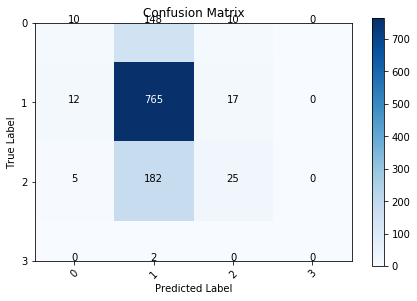

Plus 0.4807692307692308 Minus 0.37037037037037035
{'loss': 0.5717925453825549, 'val_loss': 0.9117824421042487, 'p_m': 0.05952380952380952, 'p_m_acc': 0.37037037037037035, 'p_p': 0.1179245283018868, 'p_p_acc': 0.4807692307692308, 'p_p_acc_2': 0.7142857142857143, 'p_m_acc_2': 0.6666666666666666}
Prediction for Y_4_0.5
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 119us/sample - loss: 1.0135 - accuracy: 0.6052 - val_loss: 0.9124 - val_accuracy: 0.6386
Epoch 2/5
2386/2386 [==============================] - 0s 146us/sample - loss: 0.7674 - accuracy: 0.6920 - val_loss: 0.9197 - val_accuracy: 0.6318
Epoch 3/5
2386/2386 [==============================] - 0s 114us/sample - loss: 0.6769 - accuracy: 0.7221 - val_loss: 0.9360 - val_accuracy: 0.6446
Epoch 4/5
2386/2386 [==============================] - 0s 115us/sample - loss: 0.6300 - accuracy: 0.7456 - val_loss: 0.9129 - val_accuracy: 0.6386
Epoch 5/5
2386/2386 [=========================

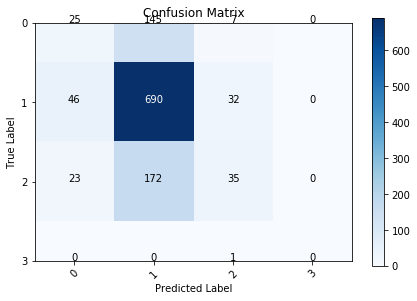

Plus 0.47297297297297297 Minus 0.26595744680851063
{'loss': 0.5704520172864973, 'val_loss': 0.9259555287101642, 'p_m': 0.14124293785310735, 'p_m_acc': 0.26595744680851063, 'p_p': 0.15217391304347827, 'p_p_acc': 0.47297297297297297, 'p_p_acc_2': 0.8333333333333334, 'p_m_acc_2': 0.5208333333333334}
Prediction for Y_5_0.5
Train on 2386 samples, validate on 1176 samples
Epoch 1/5
2386/2386 [==============================] - 0s 201us/sample - loss: 0.9725 - accuracy: 0.6119 - val_loss: 1.0030 - val_accuracy: 0.5655
Epoch 2/5
2386/2386 [==============================] - 0s 116us/sample - loss: 0.7705 - accuracy: 0.6848 - val_loss: 0.9284 - val_accuracy: 0.6250
Epoch 3/5
2386/2386 [==============================] - 0s 125us/sample - loss: 0.6847 - accuracy: 0.7242 - val_loss: 0.9321 - val_accuracy: 0.6105
Epoch 4/5
2386/2386 [==============================] - 0s 136us/sample - loss: 0.6169 - accuracy: 0.7611 - val_loss: 0.9411 - val_accuracy: 0.6344
Epoch 5/5
2386/2386 [======================

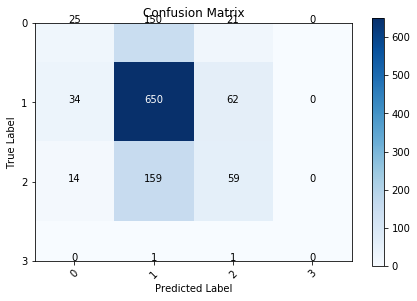

Plus 0.4154929577464789 Minus 0.3424657534246575
{'loss': 0.5741408847503471, 'val_loss': 0.9203353542454389, 'p_m': 0.12755102040816327, 'p_m_acc': 0.3424657534246575, 'p_p': 0.2543103448275862, 'p_p_acc': 0.4154929577464789, 'p_p_acc_2': 0.7375, 'p_m_acc_2': 0.6410256410256411}


In [129]:
Y=df.iloc[:,204:]
X=df.iloc[:,:204]
X=np.asarray(X)
Y=np.asarray(Y)
Y = Y.astype(np.float)
for n in range(ran):
  print(f'****Running: {n} ******')
  X_train,X_test,Y_train_1,Y_test_1 = train_test_split(X,Y,test_size=0.33)
  Y_train_arr=Y_train_1.transpose()
  Y_test_arr=Y_test_1.transpose()
  N,D=X.shape

  models_test={}
  models=[]


  for Y_val in range(10):
    pred=df.columns[204+Y_val]
    print(f'Prediction for {pred}')
    Y_train=Y_train_arr[Y_val]
    Y_test=Y_test_arr[Y_val]

    r=model.fit(X_train,Y_train,validation_data=[X_test,Y_test],epochs=5)

    p_test=model.predict(X_test).argmax(axis=1)
    cm=confusion_matrix(Y_test,p_test)
    print(f'Prediction for {pred}')
    plot_confusion_matrix(cm,list(range(4)),normalize=False)

    unique_p= np.unique(p_test,return_counts=True)
    unique_y= np.unique(Y_test,return_counts=True)


    p_m=cm[0,0]/unique_y[1][0]
    p_m_acc=cm[0,0]/(cm[0,0]+cm[1,0]+cm[2,0])
    p_m_acc_2=cm[0,0]/(cm[0,0]+cm[2,0])




    p_p=cm[2,2]/unique_y[1][2]
    p_p_acc=cm[2,2]/(cm[2,2]+cm[1,2]+cm[0,2])
    p_p_acc_2=cm[2,2]/(cm[2,2]+cm[0,2])

    matrix_p[0][Y_val][n]=p_m_acc
    matrix_p[1][Y_val][n]=p_m_acc_2
    matrix_p[2][Y_val][n]=p_p_acc
    matrix_p[3][Y_val][n]=p_p_acc_2

    models_test[Y_val]={'loss':r.history['loss'][-1],'val_loss': r.history['val_loss'][-1],\
                      'p_m': p_m,'p_m_acc':p_m_acc,'p_p': p_p,'p_p_acc':p_p_acc,\
                      'p_p_acc_2':p_p_acc_2,'p_m_acc_2':p_m_acc_2}
    print(f'Plus {models_test[Y_val]["p_p_acc"]} Minus {models_test[Y_val]["p_m_acc"]}')
    print(models_test[Y_val])
    reset_weights(model)
              

In [130]:
models_test

{0: {'loss': 0.7175781083826447,
  'val_loss': 1.025987516049625,
  'p_m': 0.0625,
  'p_m_acc': 0.12087912087912088,
  'p_p': 0.16666666666666666,
  'p_p_acc': 0.302158273381295,
  'p_p_acc_2': 0.6086956521739131,
  'p_m_acc_2': 0.2972972972972973},
 1: {'loss': 0.7631083028914043,
  'val_loss': 1.149022326582954,
  'p_m': 0.12643678160919541,
  'p_m_acc': 0.39285714285714285,
  'p_p': 0.36688311688311687,
  'p_p_acc': 0.38831615120274915,
  'p_p_acc_2': 0.6686390532544378,
  'p_m_acc_2': 0.6875},
 2: {'loss': 0.7777284781970802,
  'val_loss': 1.1284484169921096,
  'p_m': 0.21830985915492956,
  'p_m_acc': 0.3712574850299401,
  'p_p': 0.364741641337386,
  'p_p_acc': 0.502092050209205,
  'p_p_acc_2': 0.7453416149068323,
  'p_m_acc_2': 0.6813186813186813},
 3: {'loss': 0.7547408041090697,
  'val_loss': 1.1324882264039955,
  'p_m': 0.29931972789115646,
  'p_m_acc': 0.44,
  'p_p': 0.39275766016713093,
  'p_p_acc': 0.47315436241610737,
  'p_p_acc_2': 0.7121212121212122,
  'p_m_acc_2': 0.6821

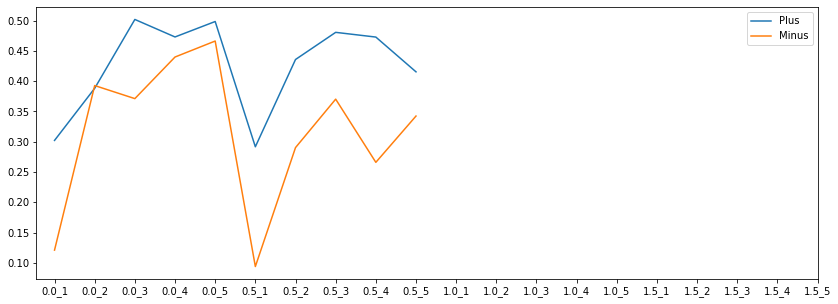

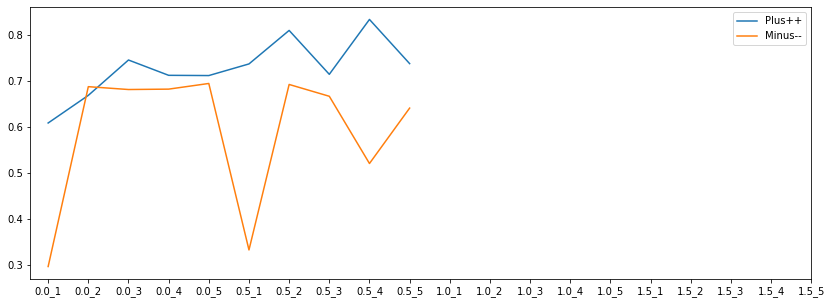

In [131]:
p_hist=[]
m_hist=[]
p2_hist=[]
m2_hist=[]
for d in models_test.values():
  p_hist.append(d['p_p_acc'])
  m_hist.append(d['p_m_acc'])
  p2_hist.append(d['p_p_acc_2'])
  m2_hist.append(d['p_m_acc_2'])

x=[x for x in range (20)]
my_xticks=[str((x // 5)/2)+'_'+str((x % 5)+1) for x in range(20)]

plt.figure(figsize=(14,5))
plt.plot(p_hist,label='Plus')
plt.plot(m_hist,label='Minus')
plt.xticks(x, my_xticks)
plt.legend()

plt.figure(figsize=(14,5))
plt.plot(p2_hist,label='Plus++')
plt.plot(m2_hist,label='Minus--')
plt.xticks(x, my_xticks)
plt.legend()

In [132]:
matrix_p[0]


array([[0.2962963 , 0.22727273, 0.10784314, 0.15277778, 0.12087912],
       [0.33333333, 0.2962963 , 0.33      , 0.38983051, 0.39285714],
       [0.38647343, 0.35828877, 0.41447368, 0.43181818, 0.37125749],
       [0.41666667, 0.37735849, 0.45856354, 0.43902439, 0.44      ],
       [0.47787611, 0.4627451 , 0.53667954, 0.50769231, 0.46641791],
       [0.17857143, 0.25      , 0.6       , 0.14285714, 0.09375   ],
       [0.26760563, 0.30769231, 0.375     , 0.3       , 0.29032258],
       [0.29347826, 0.26966292, 0.32142857, 0.36734694, 0.37037037],
       [0.38043478, 0.4109589 , 0.34306569, 0.53125   , 0.26595745],
       [0.36283186, 0.38823529, 0.38461538, 0.46376812, 0.34246575]])

In [133]:
m_hist=matrix_p[0].mean(axis=1)
m2_hist=matrix_p[1].mean(axis=1)
p_hist=matrix_p[2].mean(axis=1)
p2_hist=matrix_p[3].mean(axis=1)

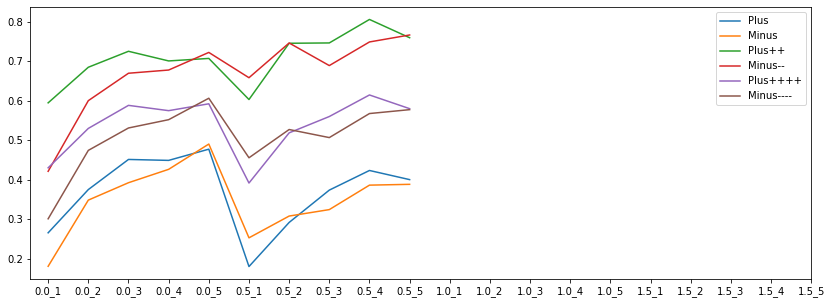

In [134]:
m_hist=matrix_p[0].mean(axis=1)
m2_hist=matrix_p[1].mean(axis=1)
p_hist=matrix_p[2].mean(axis=1)
p2_hist=matrix_p[3].mean(axis=1)

p3_hist=(p_hist+p2_hist)/2
m3_hist=(m_hist+m2_hist)/2

x=[x for x in range (20)]
my_xticks=[str((x // 5)/2)+'_'+str((x % 5)+1) for x in range(20)]

plt.figure(figsize=(14,5))
plt.plot(p_hist,label='Plus')
plt.plot(m_hist,label='Minus')
plt.plot(p2_hist,label='Plus++')
plt.plot(m2_hist,label='Minus--')
plt.plot(p3_hist,label='Plus++++')
plt.plot(m3_hist,label='Minus----')
plt.xticks(x, my_xticks)
plt.legend()
